In [1]:
import copy
import math

import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby

In [2]:
def get_k_furthest_nodes(graph, node_list, start_node,k):
    # Create a subgraph with the given node list
    
    subgraph = graph.subgraph(node_list).copy()
    
    # Ensure the start_node is in the subgraph
    if start_node not in subgraph:
        raise ValueError("Start node is not in the subgraph")
    
    # Calculate shortest path lengths from the start node to all other nodes
    path_lengths = nx.single_source_shortest_path_length(subgraph, start_node)
    
    # Sort nodes by their distance from the start node (furthest first)
    sorted_nodes = sorted(path_lengths.items(), key=lambda x: x[1], reverse=True)
    
    # Get the three furthest nodes
    furthest_nodes = [node for node, distance in sorted_nodes[:k]]
    
    return  furthest_nodes

In [177]:
import heapq

def min_cost_path(graph, node_costs, start, end, node_weight=1, hop_weight=1):
    # Priority queue to store (cumulative_cost, current_node, hop_count)
    priority_queue = [(node_weight * node_costs[start], start, 0)]
    # Dictionary to track the minimum cost to reach each node
    min_cost = {node: float('inf') for node in graph}
    min_cost[start] = node_weight * node_costs[start]
    # Dictionary to reconstruct the path
    previous_node = {start: None}
    
    while priority_queue:
        current_cost, current_node, hop_count = heapq.heappop(priority_queue)

        # If we reached the end node
        if current_node == end:
            break

        # Explore neighbors
        for neighbor in graph[current_node]:
            new_hop_count = hop_count + 1
            new_cost = current_cost + (node_weight * node_costs[neighbor]) + (hop_weight * new_hop_count)

            # If the new calculated cost is lower, update it
            if new_cost < min_cost[neighbor]:
                min_cost[neighbor] = new_cost
                previous_node[neighbor] = current_node
                heapq.heappush(priority_queue, (new_cost, neighbor, new_hop_count))

    # Reconstruct the path
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = previous_node[current]
    path.reverse()

    return min_cost[end], path


In [3]:
def shortest_path_between_contracted_sets(graph, set1, set2):
    # Create a copy of the graph to modify
    G = graph.copy()
    
    # Contract set1 and set2 into super nodes
    set1=sorted(set1)
    #print(set1)
    if len(set1)>1:
        for node in set1[1:]:
            G2= nx.contracted_nodes(G, set1[0], node,copy=True)
            
    set2=sorted(set2)
    if len(set2)>1:
        for node in set2[1:]:
            G2= nx.contracted_nodes(G, set2[0], node,copy=True)
    if len(set1)+len(set2)>2:   
        if G2.has_edge(set1[0],set2[0]):
            G2.remove_edge(set1[0], set2[0])
    else:
        G2=G.copy()
    # Find the shortest path between super nodes
    try:
        path = nx.shortest_path(G2, set1[0], set2[0])
        
        # Replace super nodes with actual nodes from the sets
        begin=path[1]
        end=path[-1]
        shortest_path_beg = min((nx.shortest_path(G, source=node, target=begin) for node in set1), key=lambda path: nx.path_weight(G, path, weight='weight'))
        shortest_path_end = min((nx.shortest_path(G, source=node, target=end) for node in set2), key=lambda path: nx.path_weight(G, path, weight='weight'))
        fin_path=[]
        fin_path.extend(shortest_path_beg)
        fin_path.extend(path[2:])
        fin_path[-1]=shortest_path_end[-1]
        return fin_path
    except nx.NetworkXNoPath:
        return None

In [4]:
def shortest_path_between_contracted_sets_with_mapping(graph, set1, set2,target_id,max_probabilities,targets,path_main):
    # Create a copy of the graph to modify
    G = graph.copy()
    G2=G.copy()
    entry=0
    to_be_removed=[]

   
    max_prob_target=max_probabilities
    '''for node in subgraph.nodes():
        max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
'''
    #print(max_prob_target)
    #print(target[0])
   
    # Contract set1 and set2 into super nodes
    set1=sorted(set1)
    #print(set1)
    for node in set1[1:]:
        G2= nx.contracted_nodes(G2, set1[0], node,copy=True)
        
    set2=sorted(set2)
    for node in set2[1:]:
        G2= nx.contracted_nodes(G2, set2[0], node,copy=True)
    
    if G2.has_edge(set1[0],set2[0]):
        G2.remove_edge(set1[0], set2[0])
        
        
    #remove truthful nodes
    for node in list(G2.nodes):
        if (node != entry and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(G2.nodes)

    for node in to_be_removed:
        if nx.has_path(G2, set1[0], set2[0]):
            dummy_sub=G2.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,set1[0],set2[0]):
                G2.remove_node(node)
    #print(G2.nodes)
    # Find the shortest path between super nodes
    try:
        path = nx.shortest_path(G2, set1[0], set2[0])
        
        # Replace super nodes with actual nodes from the sets
        begin=path[1]
        end=path[-1]
        shortest_path_beg = min((nx.shortest_path(G, source=node, target=begin) for node in set(set1).intersection(set(path_main))), key=lambda path: nx.path_weight(G, path, weight='weight'))
        shortest_path_end = min((nx.shortest_path(G, source=end, target=node) for node in set(set2).intersection(set(path_main))), key=lambda path: nx.path_weight(G, path, weight='weight'))
        fin_path=[]
        fin_path.extend(shortest_path_beg)
        fin_path.extend(path[2:-1])
        fin_path.extend(shortest_path_end)
        return fin_path
    except nx.NetworkXNoPath:
        return None

In [5]:
def union_intersect(dict_of_sets, keys, other_set):
    """
    Perform the union of sets from a dictionary based on given keys,
    then intersect the result with another set.

    Args:
    dict_of_sets (dict): A dictionary where values are sets.
    keys (list): A list of keys to select sets from the dictionary.
    other_set (set): Another set to intersect with the union result.

    Returns:
    set: The intersection of the union of selected sets with other_set.
    """
    # Select sets from the dictionary based on the given keys
    selected_sets = [dict_of_sets[k] for k in keys if k in dict_of_sets]
    
    # If no sets were selected, return an empty set
    if not selected_sets:
        return set()
    
    s = set()
    
    for item in other_set:
        s.add(item)
    
    # Perform the union of the selected sets
    union_result = set.union(*selected_sets)
    
    # Intersect the union result with the other set
    final_result = list(union_result.intersection(s))
    
    return union_result


In [6]:
def farthest_nodes(graph, entry_node, num_targets):
    # Step 1: Calculate distances from the entry node to all other nodes
    distances = nx.single_source_shortest_path_length(graph, entry_node)
    
    # Step 2: Sort nodes by distance from entry node (farthest first)
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    farthest_candidates = [node for node, dist in sorted_nodes]
    
    # Step 3: Select target nodes that are also far from each other
    selected_targets = []
    
    min_dist = nx.diameter(graph)
    while len(selected_targets) < num_targets+1:
        for candidate in farthest_candidates:
            # Check if the candidate is far enough from the already selected targets
            if all(nx.shortest_path_length(graph, candidate, target) >= min_dist for target in selected_targets):
                selected_targets.append(candidate)
        min_dist-=1
    if 0 in selected_targets:
        selected_targets.remove(0)
    return selected_targets

In [7]:
def create_physical_graph(n, p, num_targets,min_weight,max_weight):
    edges = combinations(range(n), 2)
    G = nx.path_graph(n)
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        G= nx.complete_graph(n, create_using=G)
        for u, v in G.edges():
        
            #G[u][v]['capacity'] = random.randint(-10,-1)
            G[u][v]['weight'] = random.uniform(min_weight,max_weight)
        return G
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    #G=nx.barabasi_albert_graph(n,int(p*10))
    for u, v in G.edges():
        
            #G[u][v]['capacity'] = random.randint(-10,-1)
            G[u][v]['weight'] = abs((u) - (v) )*random.uniform(min_weight,max_weight)
    G.nodes[0]['type'] = 'entry'
    target_nodes=farthest_nodes(G,0,num_targets)[:num_targets]
    for t in target_nodes:
        G.nodes[t]['type'] = 'target'
    return G,target_nodes

In [127]:
def find_sensors(d, set1, set2):
    return [k for k, v in d.items() if set1 in v and set2 in v]

In [51]:
def filter_dict(d, allowed_list):
    return {k: v for k, v in d.items() if any(x not in [y for i, w in d.items() if i != k for y in w] and x in allowed_list for x in v)}

In [115]:
def get_nodes_within_distance(start_node, max_distance,graph,max_nodes_per_sensor):
    distances = nx.single_source_dijkstra_path_length(graph, start_node, cutoff=max_distance, weight='weight')
    #print(distances)
    
    return set(list(distances.keys())[:max_nodes_per_sensor])
def create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor):
    all_covered_nodes = set()
    init_rad=sensor_radius
    i=1
    while set(all_covered_nodes) != set(Gp.nodes()):
        all_covered_nodes = set()
        C = {v: set() for v in Gp.nodes()}
        S = {s: set() for s in range(num_sensors)}
        senseo_edge_mapping={s: set() for s in range(num_sensors)}
        graph=Gp.copy()
        available_nodes = set(graph.nodes())
        to_keep=[random.choice(list(available_nodes))]
        centers=set()
        for sensor in range(num_sensors):
                     
           # print('Available',available_nodes)
            if not available_nodes:
                graph=Gp.copy()
                available_nodes=set(graph.nodes())-centers
                to_keep=available_nodes
                graph.remove_nodes_from(centers)
            start_node = random.choice(list(to_keep))
            centers.add(start_node)
            #print(graph.nodes())
            covered_nodes = get_nodes_within_distance(start_node, sensor_radius,graph,max_nodes_per_sensor)

                
            to_keep=get_k_furthest_nodes(graph,covered_nodes,start_node,inter_param)
            to_remove=[]
            for node in graph.nodes():
                if node in covered_nodes:
                    all_covered_nodes.add(node)
                    if node not in to_keep:
                        to_remove.append(node)
            
            S[sensor] = covered_nodes
            for node in covered_nodes:
                C[node].add(sensor)
            available_nodes -= covered_nodes
            graph.remove_nodes_from(to_remove)
            sing_cent=random.choice(list(to_keep))
            new_centers=sing_cent
            #get_nodes_within_distance(sing_cent, sensor_radius*0.7,graph,max_nodes_per_sensor)
            new_centers=[sing_cent]
                #get_k_furthest_nodes(graph,new_centers,sing_cent,inter_param))
            to_keep=new_centers
        #print(all_covered_nodes)
        
        if set(all_covered_nodes) != set(Gp.nodes()):
            sensor_radius+= 1
            i+=1
            if i >=10 :
                num_sensors+=1
                i=1
                #print(num_sensors)
            
        '''for sensor in range(num_sensors):
            if not S[sensor]:
                start_node = random.choice(list(Gp.nodes()))
                covered_nodes = get_nodes_within_distance(start_node, sensor_radius)
                S[sensor] = covered_nodes
                for node in covered_nodes:
                    C[node].add(sensor)'''
    print('Radius',sensor_radius)
    #S = {k: v for k, v in S.items() if len(v) > 1}
    C = {k: {item for item in v if item in S.keys()} for k, v in C.items()}
    print('Number of sensors',len(S.keys()))
    
    senseo_edge_mapping={s: set() for s in range(num_sensors)}
    for s in S.keys():
        hold=set()
        for (j,k) in Gp.edges():
            #print((j,k))
            if (j in S[s]) and (k in S[s]):
                hold.add((j,k))
        #print(hold,s)
        senseo_edge_mapping[s]=hold
                
                
    return C, S,senseo_edge_mapping

def create_sensor_graph(S):
    Gs = nx.Graph()
    Gs.add_nodes_from(S.keys())
    for s1 in S:
        for s2 in S:
            if s1 != s2:
                if S[s1].intersection(S[s2]) and not Gs.has_edge(s2,s1):
                    Gs.add_edge(s1, s2)
    return Gs

def draw_graphs(Gp, Gs, C, S, pos):
    plt.figure(figsize=(15, 6))
    
    # Draw physical graph
    plt.subplot(121)
    edges = Gp.edges()
    weights = [Gp[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(Gp, pos, alpha=0.2, width=weights)
    
    for node, sensors in C.items():
        if len(sensors) > 0:
            colors = [f'C{s}' for s in sensors]
            size = 300 if Gp.nodes[node].get('type') in ['entry', 'target'] else 200
            plt.pie([1]*len(sensors), colors=colors, center=pos[node], radius=size/plt.gcf().dpi*0.02)
    
    nx.draw_networkx_labels(Gp, pos, font_size=8, font_weight='bold')
    
    plt.title("Physical Graph with Sensor Coverage")
    plt.axis('equal')
    
    # Draw sensor graph
    plt.subplot(122)
    pos_s = nx.spring_layout(Gs)
    nx.draw(Gs, pos_s, with_labels=True, node_color='lightgreen', node_size=500, font_size=10, font_weight='bold')
    plt.title("Sensor Graph")
    
    plt.tight_layout()
    plt.show()



Targets [3, 82, 17, 159, 64, 78]
Radius 187
Number of sensors 28


In [116]:
def rank_nodes(subgraph, G2,t2,node_probabilities,entry,ldp):
    cross_prob_dict={}
    for node in subgraph.nodes:
        if node != entry:
            cross_prob_dict[node]={}
            for target in G2.graph['Targets']:
                cross_prob_dict[node][target]=sum([v * subgraph.graph['Target Probabilities'][k][target]\
                                                   for k,v in node_probabilities[node].items()])
    #print('Cros Prob',cross_prob_dict)
    return sorted(cross_prob_dict.items(), key=lambda x: x[1][t2], reverse=True)

In [117]:
def get_node_probabilities(G1):
    
    subgraph=G1.copy()
    node_probabilities={}
    costs={}
    max_prob_target = {}
    targets=[]
    for node in subgraph.nodes(data=True):
        if node[1].get('type')== 'target':
            targets.append(node[0])
    #print(targets)
    for node in subgraph.nodes:
        if node in targets:
            node_probabilities[node] = {node:1}
            max_prob_target[node]=(node,1)
        else:
            costs[node] = {target: nx.dijkstra_path_length(subgraph,node,target,weight='weight') for target in targets}
            #print(costs[node])
            total_cost = sum([1/costs[node][k] for k,v in costs[node].items()])
            #print(total_cost)
            node_probabilities[node] = {target: (1/cost) / total_cost for target, cost in costs[node].items()}
            #print(node_probabilities[node].items())
            #print(max(node_probabilities[node].items(), key=lambda x: x[1]))
            max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
    return node_probabilities, max_prob_target,targets,costs

In [118]:
def calculate_sensor_probabilities(node_probabilities, sensor_mapping,all_targets):
    sensor_probabilities = {}
    max_target_per_sensor = {}

    for sensor_id, nodes in sensor_mapping.items():
        # Initialize a dictionary to store cumulative probabilities for each target
        target_probabilities = {target: 0 for target in all_targets}

        for node in nodes:
            if node in node_probabilities:
                for target, probability in node_probabilities[node].items():
                    '''for all_target in all_targets:
                        if all_target not in target_probabilities:
                            target_probabilities[target] = 0'''
                    target_probabilities[target] += probability

        # Normalize the probabilities so they sum to 1
        total_probability = sum(target_probabilities.values())
        if total_probability > 0:
            for target in target_probabilities:
                target_probabilities[target] /= total_probability

        # Store the cumulative probabilities for the sensor
        sensor_probabilities[sensor_id] = target_probabilities

        # Determine the target with the maximum probability for this sensor
        if target_probabilities:
            max_target = max(target_probabilities, key=target_probabilities.get)
            max_target_per_sensor[sensor_id] = max_target

    return sensor_probabilities, max_target_per_sensor


In [250]:
def best_sensor_path_strategy(G1, G2, e1, sensor_mapping,target_id,node_mapping):
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    subgraph=G2.copy()
    to_be_removed=[]
    for sensor in list(subgraph.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed.append(sensor)
    entry_sensors=set()
    target_sensors=set()
    
    for sensor in node_mapping[e1]:
        entry_sensors.add(sensor)
    for sensor in node_mapping[target_id]:
        target_sensors.add(sensor)
    
    for sensor in to_be_removed:
        if any(nx.has_path(subgraph, source, target) for source in entry_sensors for target in target_sensors):
            dummy_sub=subgraph.copy()
            dummy_sub.remove_node(sensor)
            #print('Sensor removed',sensor)
            if sensor in target_sensors:
                target_sensors.remove(sensor)
            if sensor in entry_sensors:
                entry_sensors.remove(sensor)
            if any(nx.has_path(dummy_sub, source, target) for source in entry_sensors for target in target_sensors):
                subgraph.remove_node(sensor)
                #print('Sensor removed',sensor)
                if sensor in target_sensors:
                    target_sensors.remove(sensor)
                if sensor in entry_sensors:
                    entry_sensors.remove(sensor)
            else:
                if sensor in node_mapping[e1]:
                    entry_sensors.add(sensor)
                elif sensor in node_mapping[target_id]:
                    target_sensors.add(sensor)
    path=min((nx.shortest_path(subgraph, source, target) for source in entry_sensors for target in target_sensors if nx.has_path(subgraph, source, target)), key=len, default=None)
    
    considered_nodes=set()
    for sensor in path:
        for node in sensor_mapping[sensor]:
            considered_nodes.add(node)
    #print(considered_nodes)
    node_subgraph= nx.subgraph(G1,considered_nodes).copy()
    #print('Node subgraph',node_subgraph)
    min_cost=float('inf')
    to_be_removed=[]
    temp_ldp=None
    ldp=None
    for node in list(node_subgraph.nodes):
        if (node != e1 and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(to_be_removed)
    non_deceptive_ldp=None
    for node in list(node_subgraph.nodes):
        if node not in to_be_removed:
            #print(target[0])
            #print(costs[node].get(target[0]))
            if costs[node].get(target_id) < min_cost:
                min_cost = costs[node].get(target_id)
                temp_ldp = node
               # print('Current temp ldp:',temp_ldp)
        else:
            if node not in targets:
                if costs[node].get(target_id) < min_cost:
                    min_cost = costs[node].get(target_id)
                    non_deceptive_ldp = node
                    #print('Current non deceptive ldp:',temp_ldp)
    if not temp_ldp:
        temp_ldp=non_deceptive_ldp
        print('LDP in NOT DECEPTIVE')
    #print('Temp',temp_ldp)
    #print('Neighbors',list(subgraph.neighbors(temp_ldp)))
    min_cost=float('inf')
    if target_id not in node_subgraph.neighbors(temp_ldp):
        for node in node_subgraph.neighbors(temp_ldp):
            if node not in targets:
                if costs[node].get(target_id) < min_cost:
                    min_cost = costs[node].get(target_id)
                    ldp = node
                    if ldp in to_be_removed:
                        to_be_removed.remove(ldp)
    else:
        ldp= temp_ldp
        if ldp in to_be_removed:
            to_be_removed.remove(ldp)
    #print(ldp)
    
    for node in to_be_removed:
        if node != e1 and nx.has_path(node_subgraph, e1, ldp):
            dummy_sub=node_subgraph.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,e1,ldp):
                node_subgraph.remove_node(node)


    # Calculate the shortest path from entry to LDP
    node_path = nx.shortest_path(node_subgraph, source=e1, target=ldp, weight='weight')
    #print(node_path)
    print('Sensor path:',path)
    print('Node path:',node_path)
    print('Work left:' ,nx.shortest_path(G1, source=ldp, target=target_id, weight='weight'))
    print('Number of truthful steps',len(set(to_be_removed).intersection(set(node_path))))
            
    

In [288]:
def best_physical_path_strategy_(G1, G2, e1, sensor_mapping,target_id,node_mapping):
    '''    targets=[]
    for node in subgraph.nodes():
        if subgraph[node]['type'] == 'target':
            targets.append(node)'''
    entry=e1
    paths=[]
    subgraph=G1.copy()
    min_cost = float('inf')
    temp_ldp= None
    ldp = None
    to_be_removed=[]

   
    node_probabilities,max_prob_target,targets,costs = get_node_probabilities(subgraph)
    '''for node in subgraph.nodes():
        max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
'''
    #print(max_prob_target)
    #print(target[0])
    for node in list(subgraph.nodes):
        if (node != entry and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    #print(to_be_removed)
    for node in list(subgraph.nodes):
        if node not in to_be_removed:
            #print(target[0])
            #print(costs[node].get(target[0]))
            if costs[node].get(target_id) < min_cost:
                min_cost = costs[node].get(target_id)
                temp_ldp = node
    #print(temp_ldp)
    #print('Neighbors',list(subgraph.neighbors(temp_ldp)))
    min_cost = float('inf')
    if target_id not in subgraph.neighbors(temp_ldp):
        for node in subgraph.neighbors(temp_ldp):
            if node not in targets:
                if costs[node].get(target_id) < min_cost:
                    min_cost = costs[node].get(target_id)
                    ldp = node
                    if ldp in to_be_removed:
                        to_be_removed.remove(ldp)
    else:
        ldp= temp_ldp
        if ldp in to_be_removed:
            to_be_removed.remove(ldp)
    path2=nx.shortest_path(G1, source=ldp, target=target_id, weight='weight')
    
    for node in to_be_removed:
        if node != entry and node != ldp and nx.has_path(subgraph, entry, ldp):
            dummy_sub=subgraph.copy()
            dummy_sub.remove_node(node)
            if nx.has_path(dummy_sub,entry,ldp):
                subgraph.remove_node(node)


    # Calculate the shortest path from entry to LDP
    path = nx.shortest_path(subgraph, source=entry, target=ldp, weight='weight')
    fin_g=G1.copy()
    fin_g.remove_nodes_from(path[:-1])
    path2=nx.shortest_path(fin_g, source=ldp, target=target_id, weight='weight')
    weight_left=nx.path_weight(G1,path2,weight='weight')
    weight_covered=nx.path_weight(G1,path,weight='weight')
    #paths.append(path)
    store1=[]
    store2=[]
    
    considered_sensors=set()
    for node in path:
        for sensor in G2.nodes:
            if node in sensor_mapping[sensor]:
                considered_sensors.add(sensor)
                
    
    #subgraph2=G2.subgraph(considered_sensors).copy()
    
    adjusted_mapping=copy.deepcopy(sensor_mapping)
    for sensor,mapping in adjusted_mapping.items():
        new_map=set()
        if set(path).intersection(mapping):
            adjusted_mapping[sensor]=mapping
    adjusted_mapping = {k: v for k, v in adjusted_mapping.items() if v}
    subgraph2=create_sensor_graph(adjusted_mapping)
    #print(adjusted_mapping)
    #nx.draw(subgraph2, with_labels=True)
    adjusted_mapping2=copy.deepcopy(sensor_mapping)
    
    covered_nodes=set()
    for sensor,mapping in adjusted_mapping2.items():
        new_map=set()
        for node in mapping:
            if node in path:
                new_map.add(node)
        
        adjusted_mapping2[sensor] = new_map
    adjusted_mapping1 = {k: v for k, v in adjusted_mapping2.items() if v}
    subgraph1=nx.subgraph(Gs,adjusted_mapping2.keys()).copy()
    #subgraph3=create_sensor_graph(adjusted_mapping2)
    adjusted_mapping2 = filter_dict(adjusted_mapping1,Gp.nodes())
    subgraph3=nx.subgraph(Gs,adjusted_mapping2.keys()).copy()
    if not nx.is_connected(subgraph3):
        subgraph3=subgraph1.copy()
        adjusted_mapping2=adjusted_mapping1.copy()
        
    #print(adjusted_mapping)
    #nx.draw(subgraph3, with_labels=True)
    #print(path2)
    
    
    
    #adjusted_mapping2 = {k: v for k, v in adjusted_mapping2.items() if len(v) > 1}
    print('Considered sensors',adjusted_mapping2.keys(),'Maximum:',nx.diameter(subgraph3)+1)
    print('Work left',path2)
    truthful_steps=len(set(to_be_removed).intersection(set(path)))
    print('Truthful steps',truthful_steps,set(to_be_removed).intersection(set(path)))
    print('Weight covered:',weight_covered,'Weight left:',weight_left)
    deceptiveness=(len([step for step in path2 if step not in path])+truthful_steps)/(len(path)+len(path2))
    print('Path deceptiveness',1-deceptiveness)
    return path,adjusted_mapping2,subgraph3,target_id,max_prob_target,targets


In [ ]:
# Parameters
num_physical_nodes = 200
probability = 0.5
num_targets = 6
num_sensors = 8
sensor_radius = 1  # This now represents the maximum cumulative edge weight
inter_param=3#Represents the connectivity of the sensor graph
max_nodes_per_sensor=10
min_weight=1
max_weight=6

# Generate physical graph and coverage mapping
Gp,targets = create_physical_graph(num_physical_nodes, probability, num_targets,min_weight,max_weight)
print('Targets',targets)

pos = nx.spring_layout(Gp)
C, S, Se = create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor)
for (s,t) in Gp.edges():
   if not any((s,t) in values for values in Se.values()):
       Gp.remove_edge(s,t)
       #print('Removed',(s,t))
# Create sensor graph based on coverage zones
Gs = create_sensor_graph(S)

# Draw graphs
#draw_graphs(Gp, Gs, C, S, pos)
#print(Se)

In [ ]:
target_start=random.choice(targets)
print('Target is node:',target_start)

Considered sensors dict_keys([18, 19, 20, 21, 22, 23]) Maximum: 6
Work left [61, 65, 64]
Truthful steps 5 {43, 44, 45, 17, 62}
Weight covered: 117.60869586290103 Weight left: 10.875617479000358
Path deceptiveness 0.631578947368421
Node path [0, 7, 14, 15, 16, 17, 18, 19, 20, 28, 29, 43, 44, 45, 62, 61]


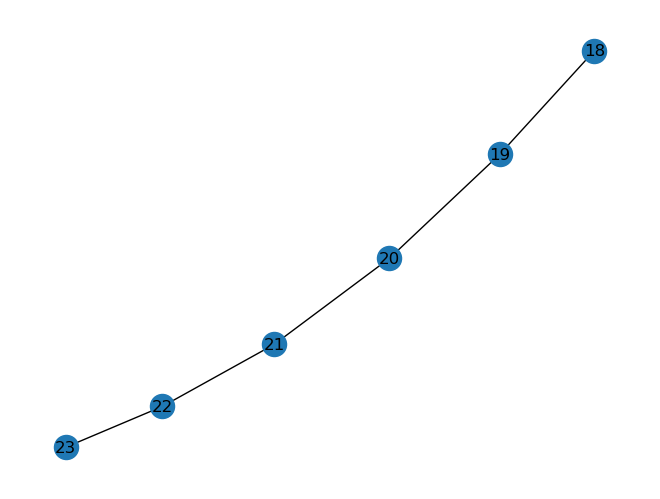

In [289]:

path,update,s4,target,max_probs,targets=best_physical_path_strategy_(Gp,Gs,0,S,target_start,C)
nx.draw(s4, with_labels=True)
print('Node path',path)
        
        
    

In [290]:
best_sensor_path_strategy(Gp,Gs,0,S,target_start,C)

Sensor path: [23, 22, 25, 17, 18]
Node path: [0, 7, 14, 15, 16, 17, 18]
Work left: [18, 19, 20, 28, 29, 43, 44, 45, 62, 63, 64]
Number of truthful steps 1
